# Proiect IVOM laborator: Clasificarea fetelor pe setul de date Cohn-Kanade
Studenti:   Sebastian Petre;
            George Margineanu;
            Cosmin Hirsescu
            
Master SIVA

# Descrierea temei: 
Am ales proiectul nr. 3, unde avem de extras trasaturile din imagini cu HOG (Histogram of oriented gradients) si clasificarea cu SVM (Support Vector Machine).

Descriere set de date Cohn-Kanade (CK+):    
    Conține 593 de secvențe video dintr-un total de 123 de subiecți diferiți, cu vârste cuprinse între 18 și 50 de ani, cu o varietate de genuri. Fiecare videoclip arată o schimbare a feței de la expresia neutră la o expresie maximă vizată, înregistrată la 30 de cadre pe secundă (FPS) cu o rezoluție de 640x490 sau 640x480 pixeli. Dintre aceste videoclipuri, 327 sunt etichetate cu una dintre cele șapte clase de expresie: furie, dispreț, dezgust, frică, fericire, tristețe și surpriză. Baza de date CK+ este considerată pe scară largă drept cea mai utilizată bază de date de clasificare a expresiei faciale controlată de laborator disponibilă și este utilizată în majoritatea metodelor de clasificare a expresiei faciale.

# Citire set de date
Incepem prin a citi imaginile din fiecare folder si creem liste cu calea acestora. 

In [49]:
import os
import re
import glob
import numpy as np

test_path = 'D:\IVOM\\test\\'
train_path = 'D:\IVOM\\train\\'

annotation_train_path = 'D:\IVOM\\annotations_train\\'
annotation_test_path = 'D:\IVOM\\annotations_test\\'

def read_annotations(path):
    annotations= os.listdir(path)
    new_paths = [ path + i + '\\' for i in annotations]
    classes = []
    classes.append([os.listdir(i) for i in new_paths])    
    return classes

def correlation_annotation_images(path):
    folders = os.listdir(path)
    new_paths = [ path + i + '\\' for i in folders]
    images = []
    images.append([os.listdir(i) for i in new_paths])
    return images

annotation_train = read_annotations(annotation_train_path)
annotation_test = read_annotations(annotation_test_path)

train = correlation_annotation_images(train_path)
test = correlation_annotation_images(test_path)
print(train[0][1])

for i in annotation_train:
    emotie = []
    for j in i:
        temp1 = []
        for k in j:
            #print(re.split('001|002|003|004|005|006|007|008|009',k)[1])
            clasa = re.split('001|002|003|004|005|006|007|008|009',k)[1]
            temp1.append(clasa)
        emotie.append(temp1)

print(emotie[1], '/n...etc')

['001', '002', '003', '004', '005', '006']
['S', 'G', 'D', 'F', 'A', 'H'] /n...etc


Setul de date este preimpartit astfel:
-  train set: foldere numerotate S056 -> S138 (83 de foldere) ce contin 1 sau mai multe foldere cu imagini cu o emotie. Am decis sa pastram ultimele 6 imagini din fiecare, deoarece ele reprezinta intensitatea maxima a emotiei.
Pentru fiecare folder cu imagini, exista un folder corespondent in annotations_train care contine in nume tipul emotiei si este usor sa le folosim ca etichete.
-  test set: foldere numerotate S010 -> S055 (46 de foldere) ce contin, de asemenea, 1 sau mai multe foldere cu imagini cu emotie. Asemenea ca mai sus, vom lua etichetele din annotations_test pentru a calcula scorul modelelor.

De exemplu, primul folder contine 2 foldere deci 2 clase "G" si "D", al doilea 6 clase "S","G","D","F","A","H" si asa mai departe.

In [2]:
def read_images(path, list_directories):
    temp1 = os.listdir(path)
    path1 = [path + i + '\\' for i in temp1 ]
    
    path2 = []
    for i in path1:
        path2.append(glob.glob(i + '*' + '\\'))
    
    images = []
    for j in path2:
        for k in j:
            images.append(glob.glob(k + '*.png'))
    return images
    
imgs_train = read_images(train_path,train)
print(imgs_train[1], '...')

['D:\\IVOM\\train\\S056\\002\\S056_002_01170619.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170620.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170621.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170622.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170623.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170624.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170625.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170626.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170627.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170628.png'] ...


In [3]:
print(emotie[:10],'\n...etc')

[['G', 'D'], ['S', 'G', 'D', 'F', 'A', 'H'], ['S', 'H', 'G'], ['S', 'F', 'A'], ['G', 'H'], ['S', 'H'], ['F', 'S', 'G', 'H'], ['S', 'H'], ['S', 'A', 'H'], ['G', 'F', 'S', 'H']] 
...etc


Pastram ultimele 6 poze (intensitatile maxime ale emotiilor).

In [51]:
images_train_path = []
for i in range(len(imgs_train)):
    images_train_path.append(imgs_train[i][-6:])
print('Setul de antrenare are {length} de foldere cu cate 6 imagini'.format(length = len(images_train_path)))
print(images_train_path[1], '\n...')

Setul de antrenare are 391 de foldere cu cate 6 imagini
['D:\\IVOM\\train\\S056\\002\\S056_002_01170623.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170624.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170625.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170626.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170627.png', 'D:\\IVOM\\train\\S056\\002\\S056_002_01170628.png'] 
...


Desi setul de date ar trebui sa fie in tonuri de gri am gasit si imagini color, de aceea le importam .grayscale.

# Train Section

In [5]:
from PIL import Image, ImageOps

images_train_raw = []
for i in images_train_path:
    for j in i:
        images_train_raw.append(ImageOps.grayscale(Image.open(j)))

In [8]:
import matplotlib.pyplot as plt

def plot_images(images):
    fig = plt.figure(figsize=(20, 15))
    rows = 1
    columns = 4
    for index in range(1,5):
        fig.add_subplot(rows, columns, index)
        plt.imshow(images[index*5],cmap='gray')
        plt.axis('off')

Imagini originale, la 640 X 490 px

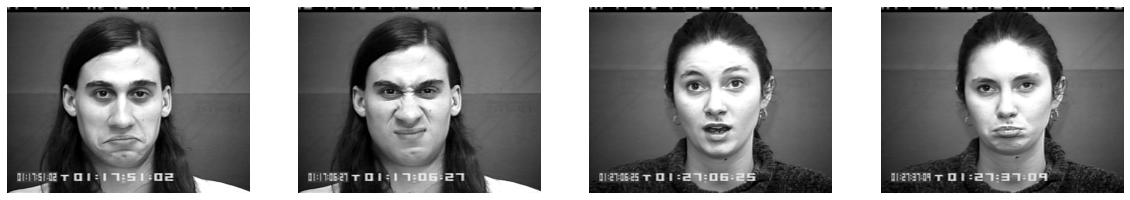

In [9]:
plot_images(images_train_raw[:24])

Pentru HOG facem reshape 245 x 320 pt toate imaginile pentru a scadea timpul de calcul pentru HOG; va dura aproximativ 2 minute.

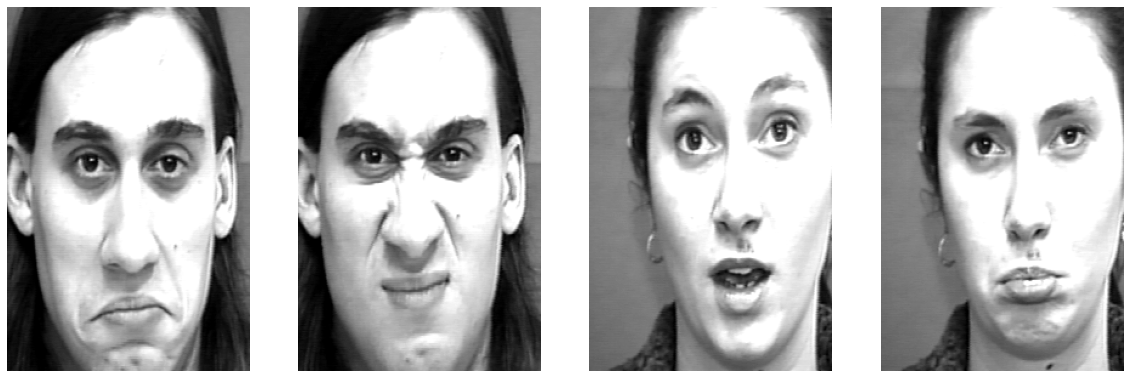

In [13]:
from skimage.transform import resize
import cv2

alpha = 1.2 # Contrast control (1.0-3.0)
beta = 0.5 # Brightness control (0-100)
new_size = (300,200)
resized_images_train =[]
rows = 1
columns = 2

for i in images_train_raw:
    i = np.array(i)
    i = cv2.convertScaleAbs(i, alpha=alpha, beta=beta)
    resized_images_train.append(resize(i[100:400,150:450], new_size))

plot_images(resized_images_train[:24])

Aplicam HOG pentru imaginile redimensionate, cu un kernel de 16.

In [15]:
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

hog_images_train = []

for i in resized_images_train:
    fd, hog_image = hog(i, orientations=9, pixels_per_cell=(16,16),
                 visualize=True,transform_sqrt=True)
    hog_images_train.append(hog_image)

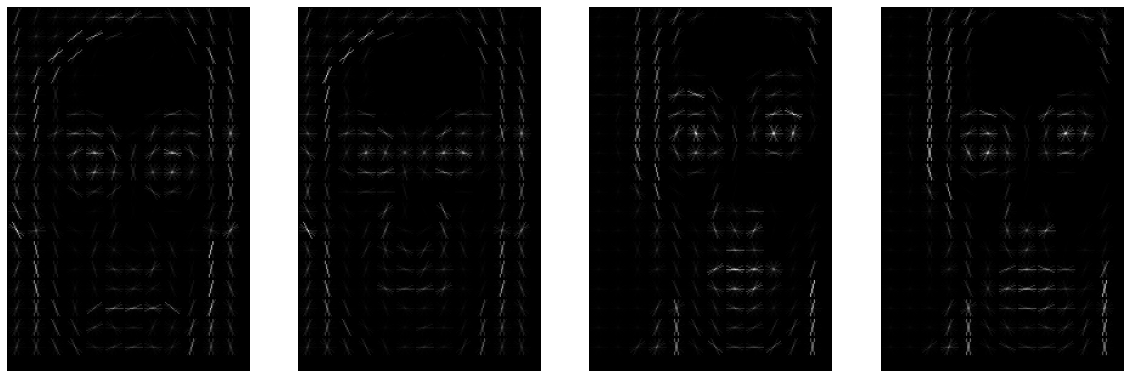

In [16]:
plot_images(hog_images_train[:24])

Accentuam valorile pixelilor in urma aplicarii HOG, transformand in 1 ce este peste pragul de 0.025.

In [17]:
train_images = []

for i in hog_images_train:
    hog_train_shape = np.shape(i)
    frame_zero = np.zeros([300,200])
    for j in range((hog_train_shape[0])):
        for k in range((hog_train_shape[1])):
            if i[j][k] > 0.025:
                frame_zero[j][k] = 1
    train_images.append(frame_zero)
    
    #Dureaza aproximativ 1 minut acest bloc

Dupa cum se vede mai jos, informatia se afla in centrul imaginii unde sunt fetele, asa ca am taiat din imagini negrul din jurul fetelor, aducand imaginile la 200 x 300 px.

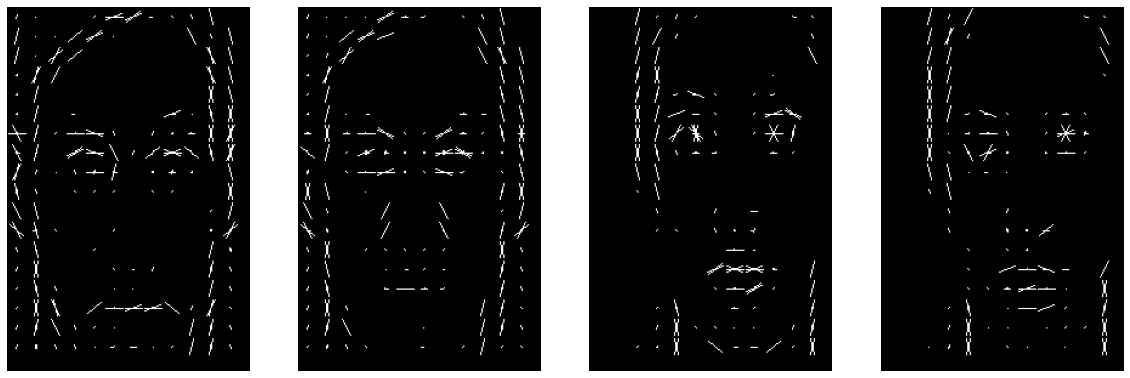

In [18]:
plot_images(train_images[0:24])

Mai jos grupam folderele in clasele Anger (A), Disgust (D), Fear (F), Happy (H), Sad (G) și Surprised (S).

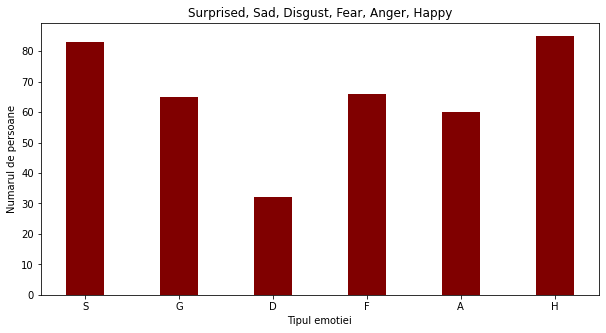

In [19]:
S, G, D, F, A, H = 0, 0, 0, 0, 0, 0 #S = surprised, G = sad 

for x in emotie:
    for y in x:
        if y == 'S':
            S += 1
        elif y == 'G':
            G += 1
        elif y == 'D':
            D += 1
        elif y == 'F':
            F += 1
        elif y == 'A':
            A += 1
        elif y == 'H':
            H += 1

data = {'S':S, 'G':G, 'D':D, 'F':F, 'A':A, 'H':H}
x = list(data.keys())
y = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(x, y, color ='maroon',
        width = 0.4)
plt.xlabel("Tipul emotiei")
plt.ylabel("Numarul de persoane")
plt.title("Surprised, Sad, Disgust, Fear, Anger, Happy")
plt.show()

Reducem toate cele 6 emotii la 2 clase:
-  Positive – happy,surprise 
-  Negative – sad,anger,fear,disgust  

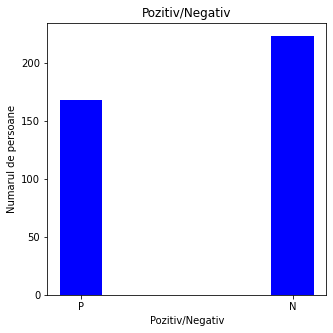

In [20]:
P, N = 0, 0 # 2 clase: Pozitiv/Negativ
for x in emotie:
    for y in x:
        if y == 'S' or y =='H': 
            P += 1
        else:
            N += 1
data_2 = {'P':P, 'N':N}

x_2 = list(data_2.keys())
y_2 = list(data_2.values())

fig = plt.figure(figsize = (5, 5))

plt.bar(x_2, y_2, color ='blue',
        width = 0.2)
plt.xlabel("Pozitiv/Negativ")
plt.ylabel("Numarul de persoane")
plt.title("Pozitiv/Negativ")
plt.show()

x_train contine imaginile trecute prin preprocesare si grupate in clasele pozitiv/negativ.

In [21]:
shape_images_train = np.shape(train_images)
x_train = np.reshape(train_images,(shape_images_train[0],shape_images_train[1]*shape_images_train[2]))

y_train reprezinta etichetele imaginilor x_train.

In [22]:
y_train = []
for i in emotie:
    for j in i:
        if j == 'H' or j == 'S':
            y_train.append(list('P')*6)
        else:
            y_train.append(list('N')*6)
y_train = np.reshape(y_train,(2346))
y_train
x = 0
for q in y_train:
    for l in q:
        if l == 'P':
            x +=1
print(x/6)

168.0


# Test Section

Repetam procesul de la setul de setul de antrenare (x_train):   
-  preprocesam imaginile (reshape+resize +contrast)
-  aplicam HOG
-  accentuam valorile pixelilor in urma aplicarii HOG, transformand in 1 ce este peste pragul de 0.025

In [52]:
for i in annotation_test:
    emotie_test = []
    for j in i:
        temp1 = []
        for k in j:
            clasa = re.split('001|002|003|004|005|006|007|008|009',k)[1]
            temp1.append(clasa)
        emotie_test.append(temp1)

print(emotie_test[1])

['S', 'G', 'F', 'A', 'D', 'H']


In [53]:
y_test = []
for i in emotie_test:
    for j in i:
        if j == 'H' or j == 'S':
            y_test.append(list('P')*6)
        else:
            y_test.append(list('N')*6)
y_test = np.reshape(y_test,(576))

In [25]:
imgs_test = read_images(test_path,test)
print(imgs_test[:1],'\n...etc')

[['D:\\IVOM\\test\\S010\\001\\S010_001_01594215.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594216.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594217.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594218.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594219.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594220.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594221.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594222.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594223.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594224.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594225.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594226.png']] 
...etc


In [54]:
images_test_path = []
for i in range(len(imgs_test)):
    images_test_path.append(imgs_test[i][-6:])
print('Setul de test are {length} de foldere cu cate 6 imagini'.format(length = len(images_test_path)))
print(images_test_path[:1], '\n...')

Setul de test are 96 de foldere cu cate 6 imagini
[['D:\\IVOM\\test\\S010\\001\\S010_001_01594221.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594222.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594223.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594224.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594225.png', 'D:\\IVOM\\test\\S010\\001\\S010_001_01594226.png']] 
...


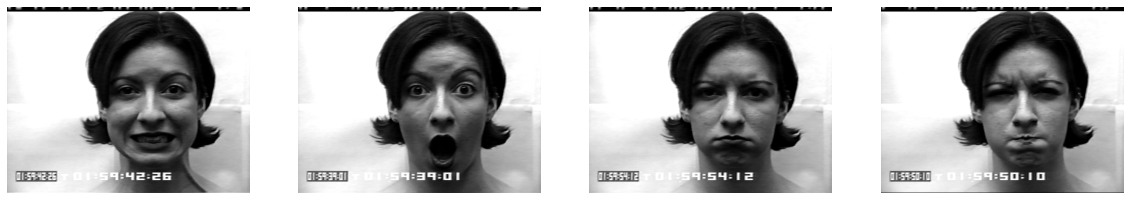

In [27]:
images_test = []
for i in images_test_path:
    for j in i:
        images_test.append(ImageOps.grayscale(Image.open(j)))

plot_images(images_test[0:24])

In [28]:
resized_images_test =[]

for i in images_test:
    i = np.array(i)
    i = cv2.convertScaleAbs(i, alpha=alpha, beta=beta)
    resized_images_test.append(resize(i[100:400,200:500], new_size))

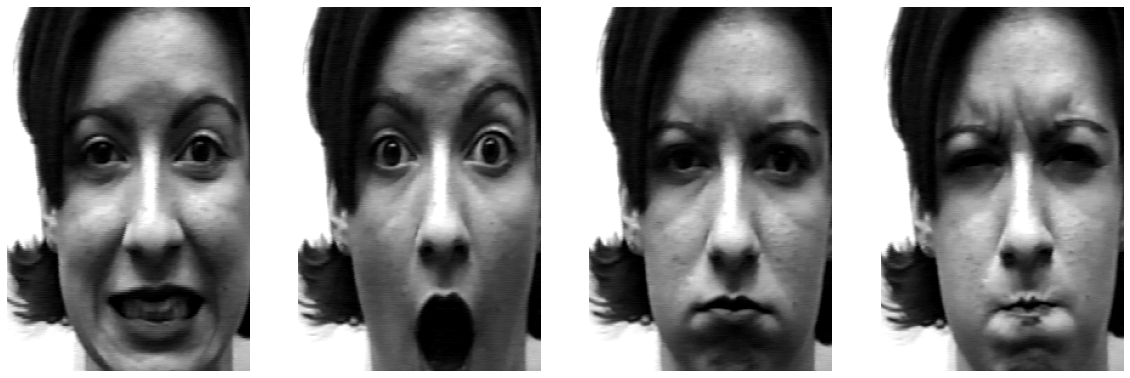

In [29]:
plot_images(resized_images_test[0:24])

In [30]:
hog_images_test = []

for i in resized_images_test:
    fd, hog_image = hog(i, orientations=9, pixels_per_cell=(16,16),
                 visualize=True,transform_sqrt=True)
    hog_images_test.append(hog_image)

In [31]:
test_images = []

for i in hog_images_test:
    hog_test_shape = np.shape(i)
    frame_zero = np.zeros([300,200])
    for j in range((hog_test_shape[0])):
        for k in range((hog_test_shape[1])):
            if i[j][k] > 0.025:
                frame_zero[j][k] = 1
    test_images.append(frame_zero)

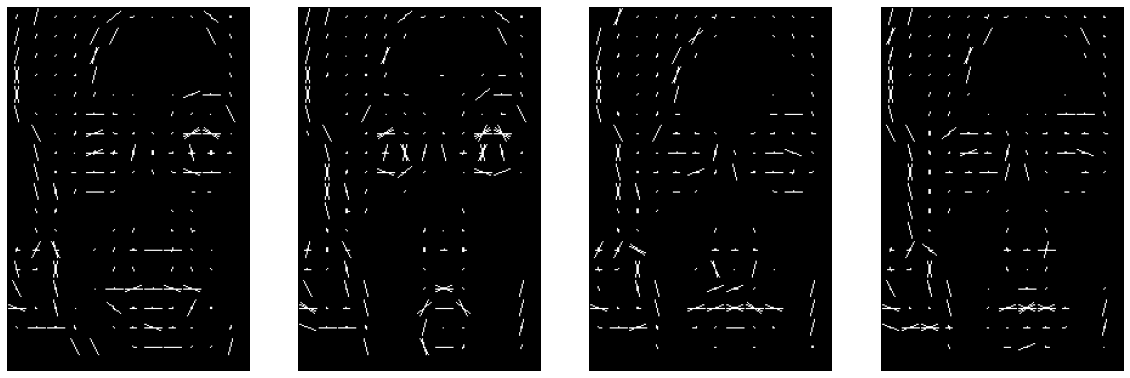

In [32]:
plot_images(test_images[:24])

x_test contine imaginile cu care vom verifica acuratetea clasificatorului SVM.

In [33]:
shape_images_test = np.shape(test_images)
x_test = np.reshape(test_images,(shape_images_test[0],shape_images_test[1]*shape_images_test[2]))

### Antrenarea modelelor alternand C si gamma. 

In [34]:
from sklearn import svm

lista_modele = []
#poly, rbf, sigmoid
clf_1 = svm.SVC(kernel= 'rbf', C = 8.9,   gamma = 0.0006)
clf_2 = svm.SVC(kernel= 'rbf', C = 8.8,   gamma = 0.0006)
clf_3 = svm.SVC(kernel= 'rbf', C = 8.7,   gamma = 0.0006)
clf_4 = svm.SVC(kernel= 'rbf', C = 8.8,   gamma = 0.0007)
clf_5 = svm.SVC(kernel= 'rbf', C = 8.7,   gamma = 0.0007)
clf_6 = svm.SVC(kernel= 'rbf', C = 8.9,   gamma = 0.0007)
clf_7 = svm.SVC(kernel= 'rbf', C = 8.7,   gamma = 0.0008)
clf_8 = svm.SVC(kernel= 'rbf', C = 8.10,  gamma = 0.0008)
clf_9 = svm.SVC(kernel= 'rbf', C = 8.8,   gamma = 0.0008)

lista_modele = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6, clf_7, clf_8, clf_9]
predict = []

y_train = y_train[:2340]

for model in range(len(lista_modele)):
    predict.append(lista_modele[model].fit(x_train,y_train))
    print("antrenare pt. modelul {model}".format(model = model))

antrenare pt. modelul 0
antrenare pt. modelul 1
antrenare pt. modelul 2
antrenare pt. modelul 3
antrenare pt. modelul 4
antrenare pt. modelul 5
antrenare pt. modelul 6
antrenare pt. modelul 7
antrenare pt. modelul 8


In [35]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

list_confusion_matrix = []
for i in range(len(lista_modele)):
    list_confusion_matrix.append(confusion_matrix(y_test,lista_modele[i].predict(x_test)))

# Acuratetea modelelor

In [44]:
for index in range(1,len(lista_modele)):
    print('Acuratetea pentru modelul clf_{index} este {scor}'.format( index = index , scor = lista_modele[index].score(x_test,y_test)))

Acuratetea pentru modelul clf_1 este 0.6180555555555556
Acuratetea pentru modelul clf_2 este 0.6163194444444444
Acuratetea pentru modelul clf_3 este 0.6284722222222222
Acuratetea pentru modelul clf_4 este 0.6284722222222222
Acuratetea pentru modelul clf_5 este 0.6267361111111112
Acuratetea pentru modelul clf_6 este 0.6336805555555556
Acuratetea pentru modelul clf_7 este 0.6354166666666666
Acuratetea pentru modelul clf_8 este 0.6371527777777778


# Matricea de confuzie pentru cele 9 combinatii de parametri

Text(0.5, 1.0, 'Confusion Matrix for Model clf_8 C = 9.8 gamma = 0.0007')

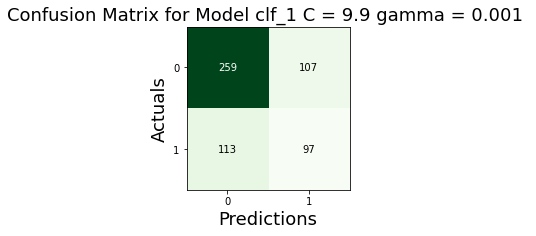

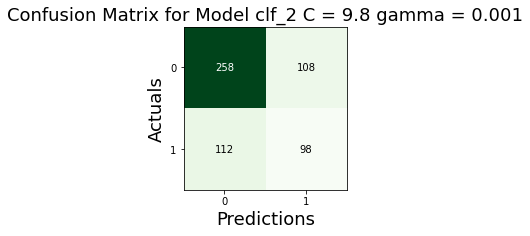

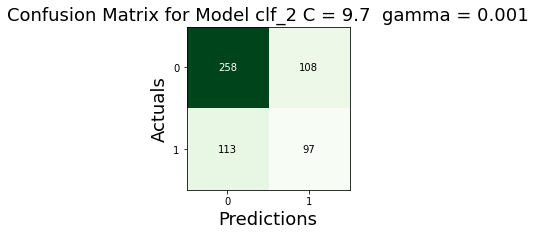

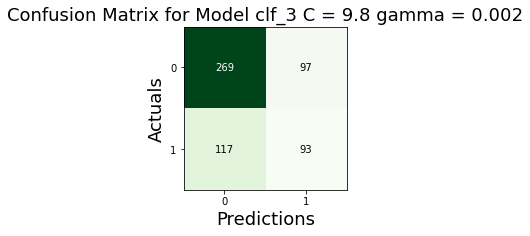

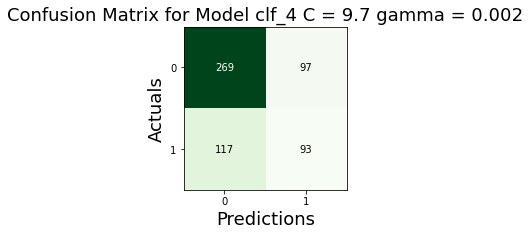

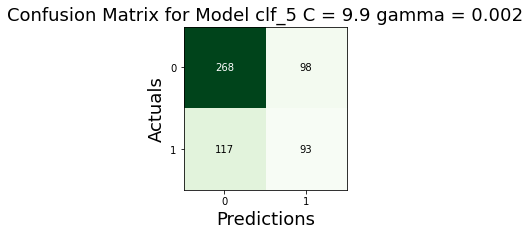

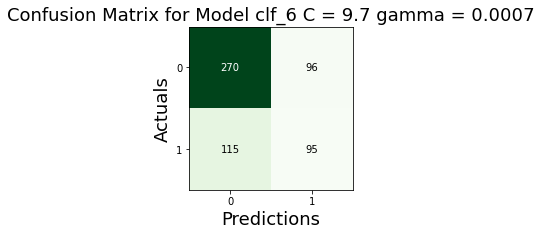

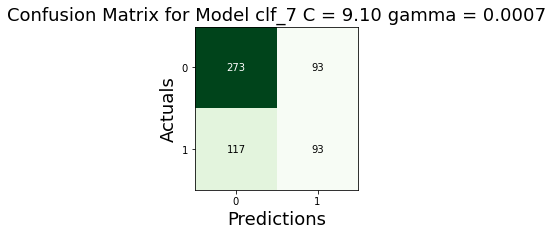

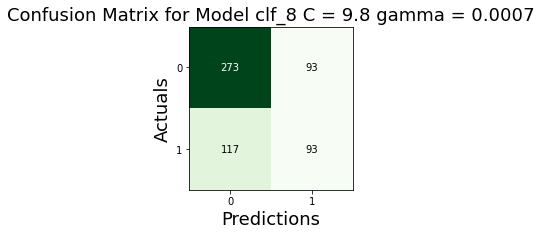

In [37]:
from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[0], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_1 C = 9.9 gamma = 0.001 ', fontsize=18)

fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[1], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_2 C = 9.8 gamma = 0.001', fontsize=18)

fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[2], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_2 C = 9.7  gamma = 0.001', fontsize=18)

fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[3], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_3 C = 9.8 gamma = 0.002', fontsize=18)

fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[4], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_4 C = 9.7 gamma = 0.002', fontsize=18)

fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[5], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_5 C = 9.9 gamma = 0.002', fontsize=18)

fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[6], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_6 C = 9.7 gamma = 0.0007', fontsize=18)

fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[7], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_7 C = 9.10 gamma = 0.0007', fontsize=18)

fig, ax = plot_confusion_matrix(conf_mat=list_confusion_matrix[7], figsize=(3, 3), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Model clf_8 C = 9.8 gamma = 0.0007', fontsize=18)

# Concluzii
Initial am testat valori pentru gamma supraunitare cu valori intregi de la 1 pana la 10 cu C > 1 si C < 1 si toate imaginile erau clasificate in clasa Positive.
Drept urmare, am ales valori pentru C in intervalul 9.7 : 9.9, iar pentru gamma 0.001 : 0.003, acestea au avut rezultate decente fata de celelalt set de parametri.
Cea mai buna acuratete de 63.71% am obtinut-o pentru modelul 9 cu parametrii C = 8.8 si gamma = 0.0008.

# Referinte
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html